In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
df.head(20)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


In [4]:
df.describe()

,WAG_C_M
count,284.000000
mean,12193.308099
std,11992.326701
min,15.300000
25%,1191.000000
50%,7195.000000
75%,21365.250000
max,43408.000000


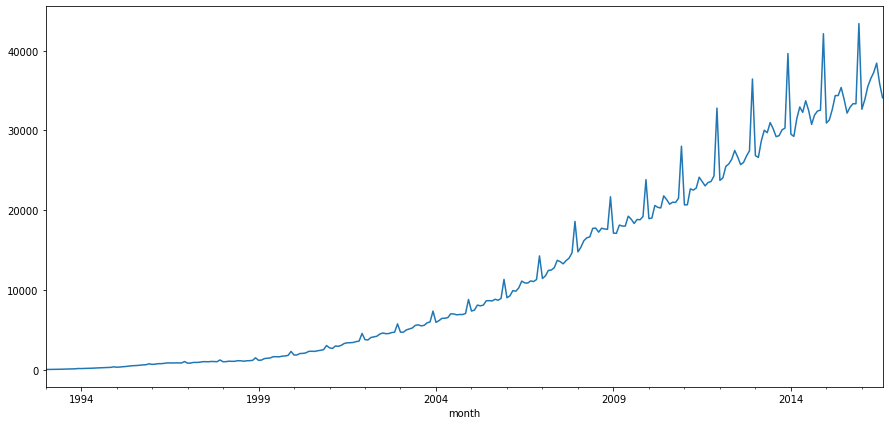

In [7]:
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.show()

Уже по графику видно, что он собрал всё, что только можно.  Ярко выражены повышающийся тренд, увеличение дисперсии, сезонность. Ряд явно не стационарен, и в данный момент для определения этого не нужен и критерий Дики-Фуллера.

<Figure size 1080x720 with 0 Axes>

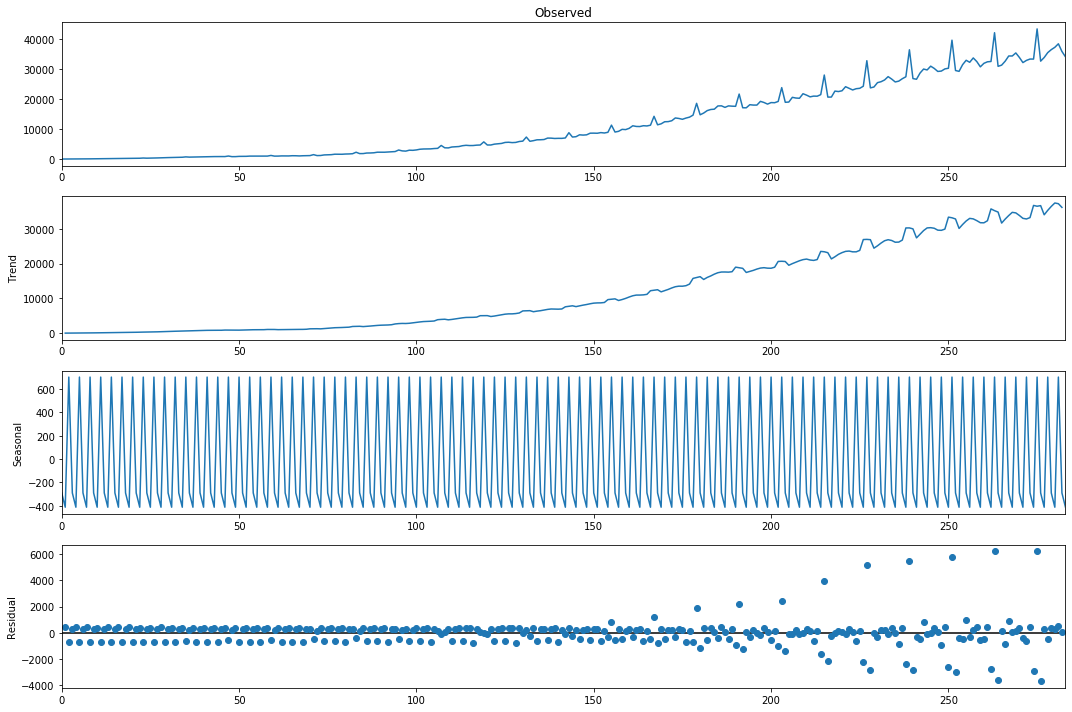

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M.values, period=3).plot()
plt.show()

In [9]:
df['WAG_box'], lmbda = stats.boxcox(df.WAG_C_M)

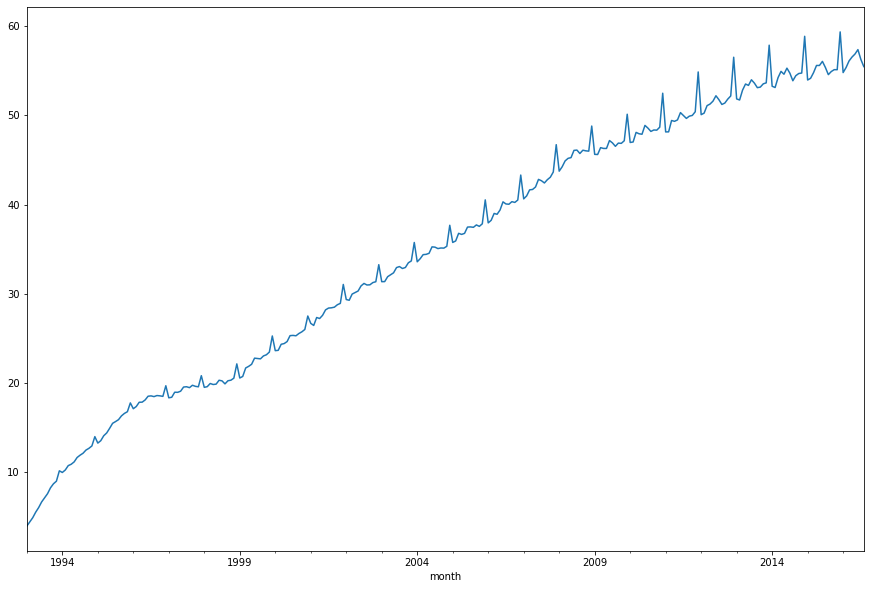

In [10]:
df.WAG_box.plot()

Дисперсия уменьшилась, но слабо, попробуем ликвидировать нестационарность, убрав тренд. Воспользуемся сезонным дифференцированием.

Критерий Дики-Фуллера: 0.014697133494791775


<Figure size 1080x720 with 0 Axes>

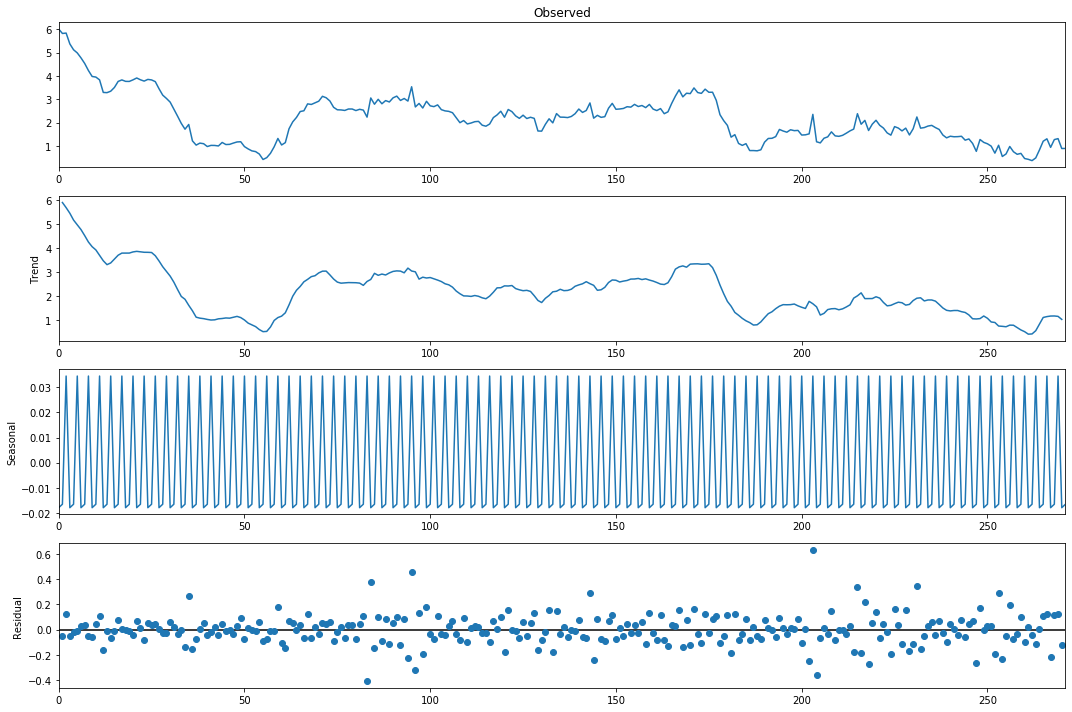

In [11]:
df['WAG_seasonal'] = df.WAG_box - df.WAG_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_seasonal[12:].values, period=3).plot()
print(f'Критерий Дики-Фуллера: {sm.tsa.stattools.adfuller(df.WAG_seasonal[12:])[1]}')

Попробуем применить обычное дифференцирование для улучшения результата.

Критерий Дики-Фуллера: 5.203603715821937e-08


<Figure size 1080x720 with 0 Axes>

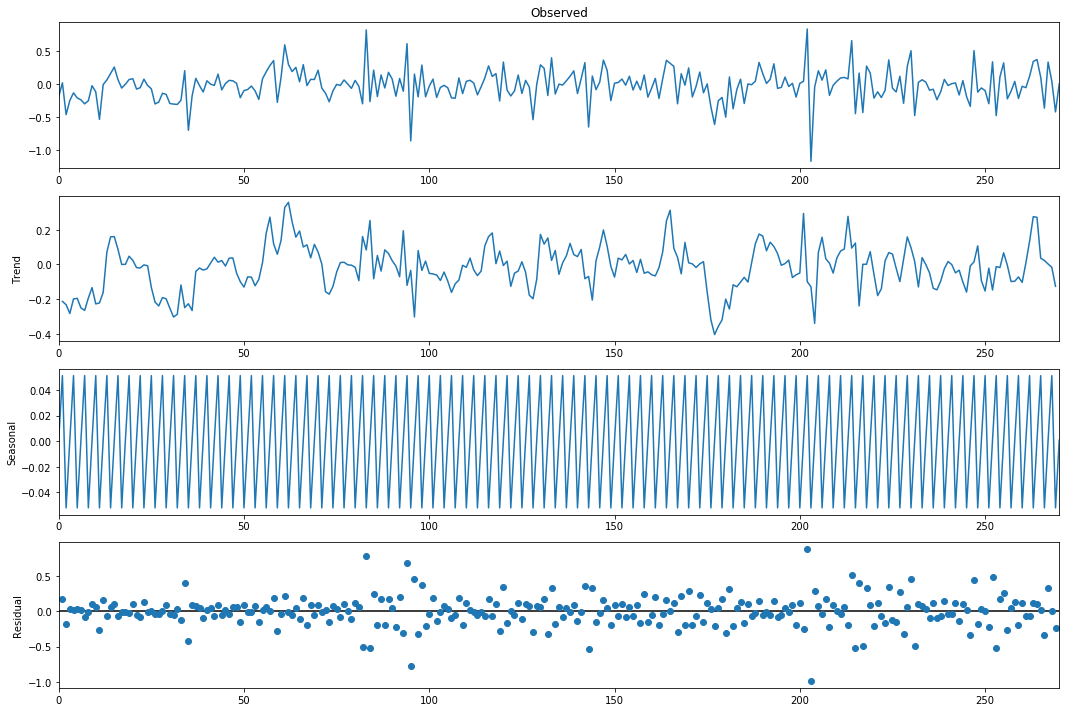

In [12]:
df['WAG_final'] = df.WAG_seasonal - df.WAG_seasonal.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_final[13:].values, period=3).plot()
print(f'Критерий Дики-Фуллера: {sm.tsa.stattools.adfuller(df.WAG_final[13:])[1]}')

Мы видим, что теперь тренд ушёл, и график стал похож на стационарный. Критерий Дики-Фуллера также уверенно отвергает нулевую гипотезу о нестационарности ряда.

Далее займёмся настройкой алгоритма. Построим частичную и полную автокореллограммы, и выберем параметры p,P,q,Q

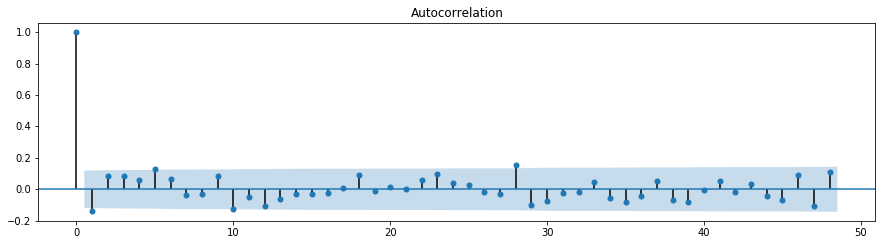

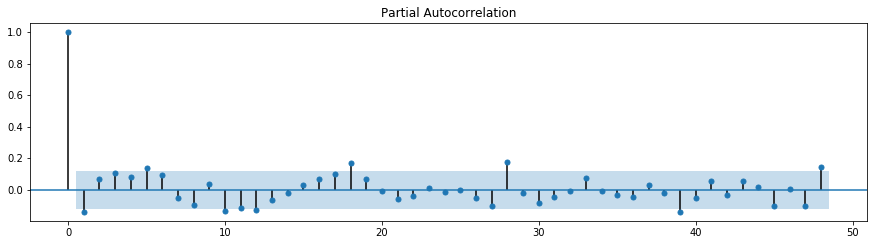

In [13]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.WAG_final[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.WAG_final[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Q = 0;
q = 1;
P = 1;
p = 5;

In [18]:
ps = range(6)
d = 1
qs = range(2)
P = range(2)
D = 1
Q = range(1)

In [19]:
parameters = product(ps, qs, P, Q)
parameters_list = list(parameters)
len(parameters_list)

24

In [20]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.WAG_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
23  (5, 1, 1, 0) -5.260134
15  (3, 1, 1, 0) -4.995859
21  (5, 0, 1, 0) -4.545934
19  (4, 1, 1, 0) -3.975974
11  (2, 1, 1, 0) -3.884138


In [22]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             WAG_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.630
Date:                             Mon, 08 Jun 2020   AIC                             -5.260
Time:                                     19:30:51   BIC                             23.557
Sample:                                 01-01-1993   HQIC                             6.310
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      

Её остатки:

Критерий Стьюдента: p=0.296170
Критерий Дики-Фуллера: p=0.000000


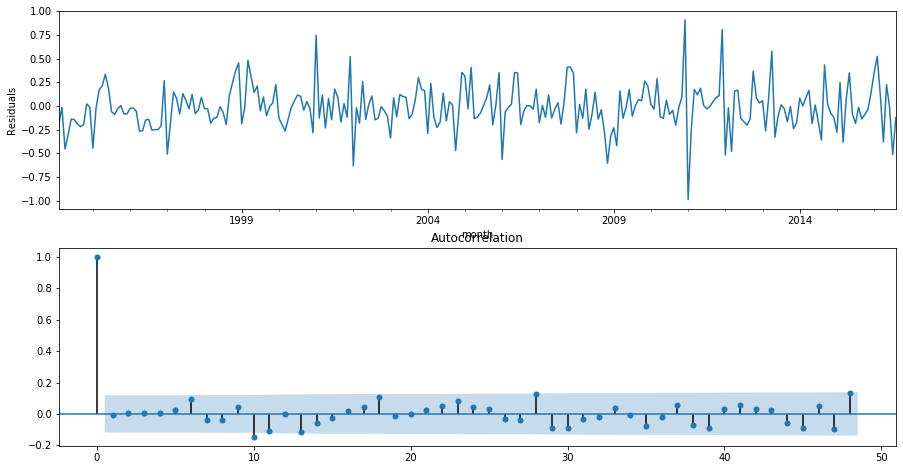

In [23]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки похожи на шум. Отсутствуют сезонность, тренд, цикличность. Также критерий Стьюдента отвергает гипотезу о смещённости, а критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности.

Посмотрим, насколько хорошо модель описывает данные.

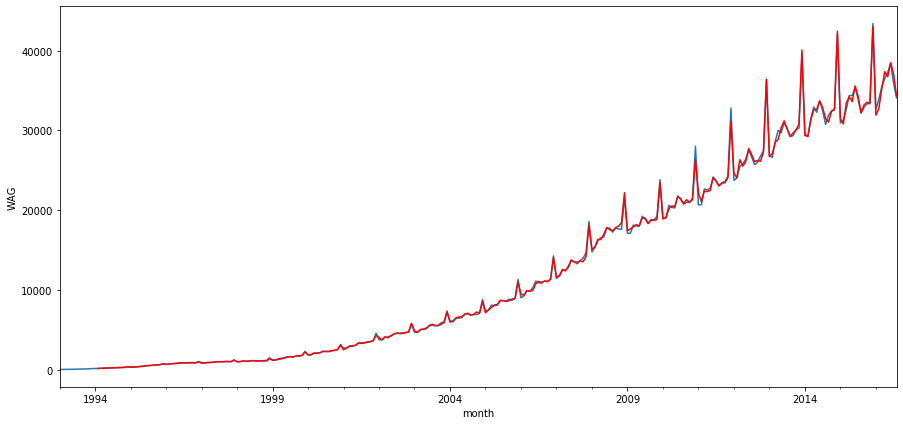

In [24]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel('WAG')
pylab.show()

Модель достаточно точно описывает существующие данные. Попробуем построить предсказание на ближайшие 3 года.

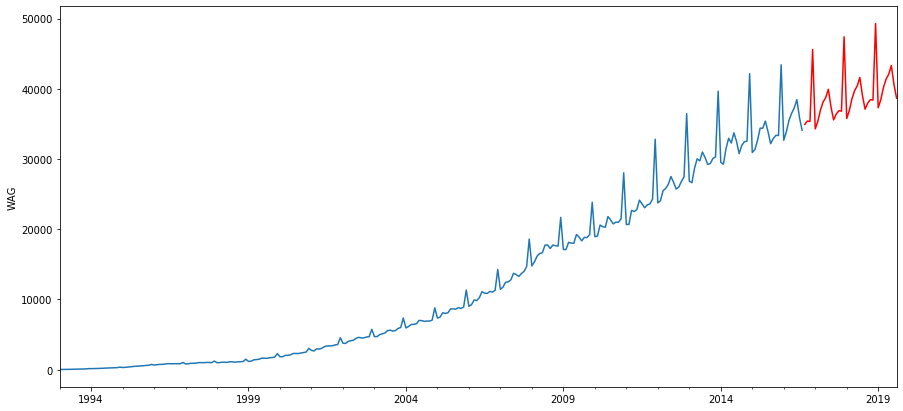

In [27]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('WAG')
pylab.show()

Видим, что полученное предсказание выглядит адекватно в сравнении с предыдущими данными ряда.